In [ ]:
# Geometric distance L2norm Regression for Homography
# https://math.stackexchange.com/questions/494238/how-to-compute-homography-matrix-h-from-corresponding-points-2d-2d-planar-homog

In [1]:
import numpy as np

In [2]:
w = 240
h = 120
x = np.linspace(0, w, w, endpoint=False)
y = np.linspace(0, h, h, endpoint=False)
xv, yv = np.meshgrid(x, y)
_one = np.ones((h,w))

In [125]:
a = np.random.randint(0,255,(120,240,3))

In [126]:
z = np.dstack([xv,yv,_one])

In [127]:
Z = z.reshape([w * h, 3]).T

In [136]:
zz = np.linalg.inv(H) @ Z
zz /= zz[-1,:]

In [137]:
zz_int  = (zz + 0.5).astype(np.int32)

In [138]:
zz_int

array([[400, 401, 401, ..., 530, 530, 531],
       [100, 100, 101, ..., 328, 328, 329],
       [  1,   1,   1, ...,   1,   1,   1]])

In [145]:
zz_convert = zz_int.T.reshape(h, w, 3)
zz_convertT = zz_int.T

In [146]:
zz_convertT.shape

(28800, 3)

In [141]:
dd = np.random.randint(0,255,(720,1280,3))

In [144]:
zz_convert.shape

(120, 240, 3)

In [151]:
cc = dd[zz_convertT[:,0],zz_convertT[:,1],:].reshape(h, w, 3)

In [153]:
cc.shape

(120, 240, 3)

In [75]:
zz_intT = zz_int.T


In [77]:
120 * 240

28800

In [83]:
zz_intT

array([[-814,   69,    1],
       [-812,   69,    1],
       [-810,   68,    1],
       ...,
       [-348,   71,    1],
       [-346,   70,    1],
       [-344,   70,    1]])

In [98]:
# Data init 
M = 4  # number of data
N = 3  # features number
data_x = np.random.rand(N,M)*1000
data_x = data_x
data_x[2,:] = 1
t_m = np.random.rand(N,N)
t_m[2,2] = 1
data_y = np.dot(t_m,data_x.copy().astype(float))

In [99]:
data_x

array([[317.01774853, 202.7995656 , 745.69012875, 956.10167685],
       [859.92436177, 460.49904137, 100.19408643, 164.36002568],
       [  1.        ,   1.        ,   1.        ,   1.        ]])

In [100]:
t_m = np.array([[ 7.92272362e-01,  8.22117652e-02,  4.34671442e+02],
       [-1.33501977e-01,  9.58413827e-01,  6.55962640e+01],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])

In [102]:
dy = data_y / data_y[-1:, :]

In [101]:
data_y = np.dot(t_m, data_x.copy().astype(float))
print(data_y)

[[7.56531742e+02 6.33202372e+02 1.03369825e+03 1.20567670e+03]
 [8.47437166e+02 4.79870770e+02 6.20725554e+01 9.54797211e+01]
 [9.47503913e-01 9.64975645e-01 8.45577900e-01 8.02582255e-01]]


In [8]:
## test self determine coord
data_x = np.array([[400, 600, 450, 620],
                  [100, 200, 620, 700],
                  [1, 1, 1, 1]]).astype(np.float32)
data_y = np.array([[0, 400, 0, 400],
                  [0, 0, 400, 400],
                  [1, 1, 1, 1]]).astype(np.float32)


In [3]:
DBG = 0
DBG_LOSS = 1
def DEBUG(*args):
    if DBG: print(*args)

def DEBUGLOSS(*args):
    if DBG_LOSS: print(*args)

In [4]:
class Variables(object):
    """
    Variable that can used to train with mask
    """
    __slots__ = ('train_mask','dim','trainable','val')
    def __init__(self, val=None, dim=None, trainable=1):
        self.dim = dim
        if val is None:
            self.val = np.random.rand(dim[0],dim[1])
            #self.val = np.zeros((dim[0],dim[1]))
        else:
            assert val.shape == dim, "input val not consistent to dim input"
            self.val = val
        self.train_mask = np.ones_like(self.val)
        self.trainable = trainable
    def set_trainMask(self, mask):
        assert mask.shape == self.dim
        self.train_mask = mask
    def update(self, dv):
        if self.trainable:
            self.val -= (dv * self.train_mask)


In [5]:
class Regression(object):
    """
    Note. Training gradient may explode if lr is too large.
    """
    __slots__ = ('var', 'iter', 'lr', 'err_th', 'j_hist',
                'x_mean', 'y_mean', 'x_std', 'y_std',
                'decay_rate', 'loss_weights','norm', 'update_steps', 'dim','data_m',
                'solver', 'loss_func')
    LOSSFUNCS = {'L2norm':0, 'L1norm':1}
    SOLVERS = {'Grad':0,'Adam':1}

    def __init__(self, var=None, dim=None, iter=500, decay_rate=0.9, norm=1, update_steps=100, data_m=0,
                solver='Grad', loss_func='L2norm'):
        self.var = var
        self.iter = iter
        self.lr = 0.001
        self.err_th = 1e-4
        self.j_hist = np.zeros((self.iter,1))
        self.decay_rate=0.9
        self.loss_weights=None
        self.update_steps=update_steps
        self.norm = norm
        self.data_m = data_m
        self.solver = solver
        self.loss_func = loss_func

    def process(self, x, y, method=0):
        if method == 0:
            return x.copy(), y.copy()
        elif method == 1:
            n, m = x.shape
            self.x_std = np.std(x,axis=1, keepdims=1)
            _x = x.copy() / self.x_std
            _y = y.copy() / self.x_std
            _x[-1,:] = x[-1,:]
            _y[-1,:] = y[-1,:]
            return _x, _y
        elif method == 2:
            self.x_mean = np.mean(x,axis=1, keepdims=1)
            self.x_std = np.std(x,axis=1, keepdims=1)
            _x = (x.copy() - self.x_mean)/self.x_std
            _y = (y.copy() - self.x_mean)/self.x_std
            return _x, _y
        return x.copy(), y.copy()
    
    def pred(W,x):
        return np.dot(W, x)
    
    def computeLoss(self, res):
        n, m = self.dim
        p, q = self.var.val.shape
        if self.loss_func == 'L2norm':
            loss = np.sum(res * res) / (2 * m * n)
        if self.norm > 0:
            loss += (np.sum(self.var.val ** 2) - 1) / (2 * p * q) * self.norm 
        return loss
    
    def lrPolicy(self, iteration, lr):
        if (iteration+1) % self.update_steps == 0:
            lr *= self.decay_rate
        return lr

    def lossDiff(self, pred, y):
        res = (pred - y)
        if self.loss_weights is not None:
            res *= self.loss_weights
        return res

    def computeGradient(self, res, _x, *args):
        n, m = self.dim
        if self.loss_func == 'L2norm':
            tV = np.dot(res, _x.T) / m
        if self.norm > 0:
            tV += self.var.val * self.norm 
        return tV
    
    def computeSolver(self, lr, tV):
        if self.solver == 'Grad':
            dV = lr * tV
        return dV

    def updateWeight(self, dV_masked):
        if self.var.trainable:
            self.var.val -= dV_masked

    def fit(self, x, y):
        assert len(x.shape) == 2, 'shape of x is not support'
        assert self.var.dim[1] == x.shape[0], 'shape of x %s is not consistent to var dim %s' % (self.var.dim, x.shape)
        assert self.var.dim[0] == y.shape[0], 'shape of y %s is not consistent to var dim %s' % (self.var.dim, y.shape)
        n, m = self.dim = x.shape
        p, q = self.var.val.shape
        print('processing data')
        _x, _y = self.process(x, y, self.data_m)
        print('output:', _x[:,0], _y[:,0])
        dv_hist = []
        lr= self.lr

        for i in range(self.iter):
            # update policy
            lr = self.lrPolicy(i, lr)

            pred = Regression.pred(self.var.val, _x)
            DEBUG('pred',pred[:,0])

            res = self.lossDiff(pred,y)
            DEBUG('res',res[0,:], '\ntv', np.dot(res, _x.T)[0,:])

            loss = self.computeLoss(res)
            self.j_hist[i,0] = loss

            if (loss < self.err_th):
                return self.var.val
            
            # Gradient
            tV = self.computeGradient(res, _x, m)
            dV = self.computeSolver(lr, tV)

            dv_hist.append(dV[0,0])

            # Update variable
            self.updateWeight(dV * self.var.train_mask)
            DEBUG('dv',dV[0,:],'val',self.var.val[0,:])
            DEBUGLOSS('==============',i,'============', 'loss',loss,'\n', self.var.val)
        print("iter Done! Final loss:", loss)
        return dv_hist
            #self.var.update(dV, self.ir, m)

In [10]:
from ransac import HomoModel, RANSAC, calcHomographyLinear, calcHomography
import numpy  as np
FILE = "matchespoints.npy"
a = np.load(FILE).tolist()
ptsA, ptsB = a['ptsA'].T, a['ptsB'].T
model = HomoModel(th=5,d=60,n=4)
ransac = RANSAC(model, k=1000)
H, inliers, _len = ransac.run([ptsA, ptsB], method="backward")
print(_len, '\n')
print(0)
H

120 

0


array([[ 7.7134585e-01, -6.6030532e-02,  4.6797086e+02],
       [-9.9737510e-02,  8.4474671e-01,  7.7643272e+01],
       [-1.5633172e-04, -1.4448377e-04,  1.0000000e+00]], dtype=float32)

In [11]:
X = ptsA[:,inliers[0]]
Y = ptsB[:, inliers[0]]
nx, mx = X.shape
xx = np.ones((nx+1,mx),dtype=np.float32)
yy = np.ones((nx+1,mx),dtype=np.float32)
xx[:2,:] = X
yy[:2,:] = Y
calcHomographyLinear(xx, yy, 1)

array([[ 7.92968750e-01,  7.03125000e-02,  4.38000000e+02],
       [-1.28967285e-01,  9.45312500e-01,  6.75000000e+01],
       [-2.00629234e-04,  0.00000000e+00,  1.00000000e+00]])

_h @ x = y
=>
x = inv(h) @ y

_h = np.linalg.inv(x @ np.linalg.inv(y))

In [295]:
_h = np.linalg.inv(xx @ np.linalg.pinv(yy))

In [309]:
a = np.zeros((mx, 2 * 9), dtype=np.float32)
a[:, 0] = -xx[0, :]
a[:, 1] = -xx[1, :]
a[:, 2] = -1
a[:, 6] = xx[0, :] * yy[0, :]
a[:, 7] = xx[1, :] * yy[0, :]
a[:, 8] = yy[0, :]
a[:, 12] = -xx[0, :]
a[:, 13] = -xx[1, :]
a[:, 14] = -1
a[:, 15] = xx[0, :] * yy[1, :]
a[:, 16] = xx[1, :] * yy[1, :]
a[:, 17] = yy[1, :]
a = a.reshape(mx * 2, 9)

In [310]:
u, s, v = np.linalg.svd(a)


In [312]:
_h = v[-1].reshape(3, 3)
    
    # norm
_h = _h / _h.item(8)

In [313]:
_h

array([[ 7.6709145e-01,  3.2906778e-02,  4.4617929e+02],
       [-1.3224585e-01,  9.0822560e-01,  7.5729874e+01],
       [-2.0791549e-04, -3.9229242e-05,  1.0000000e+00]], dtype=float32)

In [241]:
v.shape

(3, 3)

In [238]:
_h = yy @ (u @ s @ va)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 121)

In [165]:
N=3
var  = Variables(dim=(N,N))
# var.val[:,-1] = 200
var.val = np.array([[ 7.92272362e-01,  8.22117652e-02,  4.34671442e+02],
       [-1.33501977e-01,  9.58413827e-01,  6.55962640e+01],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])
mask = np.ones_like(var.val)
mask[-1,:] = 1
mask[N-1,N-1] = 0
var.set_trainMask(mask)
reg = Regression(var=var,iter=5000, update_steps=1000, data_m=0)
reg.err_th = 1e-10
#reg.lr = 0.000002
reg.lr = np.ones((N,N)) * 0.000035
reg.norm = 0
reg.loss_weights = np.array([[1,1,1]]).T

In [166]:
nx, mx = X.shape
xx = np.ones((nx+1,mx),dtype=np.float32)
yy = np.ones((nx+1,mx),dtype=np.float32)
xx[:2,:] = X
yy[:2,:] = Y

In [167]:
xx.shape

(3, 120)

In [168]:
x_mean = np.mean(xx, axis=1, keepdims=1)
data_x = (xx) / np.array([[100,100,100]]).T
data_y = (yy) / np.array([[100,100,100]]).T

In [169]:
dv_hist = reg.fit(data_x, data_y)

processing data
output: [2.47 4.63 0.01] [6.99 4.98 0.01]
============== 0 ============ loss 0.06364502057402945 
 [[ 7.92332544e-01  8.22893274e-02  4.34671442e+02]
 [-1.33465328e-01  9.58463384e-01  6.55962641e+01]
 [-2.09177753e-04  1.61886229e-05  1.00000000e+00]]
============== 1 ============ loss 0.06351712510545629 
 [[ 7.92392663e-01  8.23667928e-02  4.34671442e+02]
 [-1.33428718e-01  9.58512880e-01  6.55962642e+01]
 [-2.09107003e-04  1.62833571e-05  1.00000000e+00]]
============== 2 ============ loss 0.06338952963997001 
 [[ 7.92452720e-01  8.24441614e-02  4.34671442e+02]
 [-1.33392148e-01  9.58562316e-01  6.55962643e+01]
 [-2.09036328e-04  1.63779745e-05  1.00000000e+00]]
============== 3 ============ loss 0.06326223346960451 
 [[ 7.92512713e-01  8.25214335e-02  4.34671443e+02]
 [-1.33355617e-01  9.58611690e-01  6.55962644e+01]
 [-2.08965729e-04  1.64724751e-05  1.00000000e+00]]
============== 4 ============ loss 0.06313523588806438 
 [[ 7.92572644e-01  8.25986091e-02  4.3467

 [[ 8.00012690e-01  9.20472974e-02  4.34671462e+02]
 [-1.28799127e-01  9.64706443e-01  6.55962768e+01]
 [-2.00155776e-04  2.81345415e-05  1.00000000e+00]]
============== 138 ============ loss 0.048550702667537325 
 [[ 8.00064846e-01  9.21125255e-02  4.34671462e+02]
 [-1.28767519e-01  9.64748238e-01  6.55962769e+01]
 [-2.00094631e-04  2.82144918e-05  1.00000000e+00]]
============== 139 ============ loss 0.04845817771601969 
 [[ 8.00116947e-01  9.21776714e-02  4.34671462e+02]
 [-1.28735945e-01  9.64789982e-01  6.55962770e+01]
 [-2.00033551e-04  2.82943426e-05  1.00000000e+00]]
============== 140 ============ loss 0.048365869301170226 
 [[ 8.00168995e-01  9.22427352e-02  4.34671463e+02]
 [-1.28704404e-01  9.64831674e-01  6.55962771e+01]
 [-1.99972535e-04  2.83740943e-05  1.00000000e+00]]
============== 141 ============ loss 0.04827377691203581 
 [[ 8.00220990e-01  9.23077170e-02  4.34671463e+02]
 [-1.28672897e-01  9.64873314e-01  6.55962772e+01]
 [-1.99911583e-04  2.84537469e-05  1.000000

============== 268 ============ loss 0.0381682432039393 
 [[ 8.06411265e-01  9.99263711e-02  4.34671478e+02]
 [-1.24930848e-01  9.69762577e-01  6.55962871e+01]
 [-1.92668897e-04  3.78035932e-05  1.00000000e+00]]
============== 269 ============ loss 0.03809998464752622 
 [[ 8.06456915e-01  9.99816161e-02  4.34671478e+02]
 [-1.24903324e-01  9.69798089e-01  6.55962872e+01]
 [-1.92615597e-04  3.78714816e-05  1.00000000e+00]]
============== 270 ============ loss 0.03803188537008843 
 [[ 8.06502519e-01  1.00036791e-01  4.34671479e+02]
 [-1.24875830e-01  9.69833557e-01  6.55962873e+01]
 [-1.92562353e-04  3.79392850e-05  1.00000000e+00]]
============== 271 ============ loss 0.03796394499582228 
 [[ 8.06548077e-01  1.00091895e-01  4.34671479e+02]
 [-1.24848364e-01  9.69868980e-01  6.55962873e+01]
 [-1.92509163e-04  3.80070034e-05  1.00000000e+00]]
============== 272 ============ loss 0.03789616314981149 
 [[ 8.06593590e-01  1.00146929e-01  4.34671479e+02]
 [-1.24820927e-01  9.69904359e-01  6.55

============== 386 ============ loss 0.031119384679174494 
 [[ 8.11494962e-01  1.05980781e-01  4.34671491e+02]
 [-1.21873296e-01  9.73660636e-01  6.55962951e+01]
 [-1.86744833e-04  4.52531853e-05  1.00000000e+00]]
============== 387 ============ loss 0.03106754839503682 
 [[ 8.11535550e-01  1.06028268e-01  4.34671491e+02]
 [-1.21848950e-01  9.73691265e-01  6.55962951e+01]
 [-1.86697636e-04  4.53117000e-05  1.00000000e+00]]
============== 388 ============ loss 0.031015832645386644 
 [[ 8.11576098e-01  1.06075694e-01  4.34671491e+02]
 [-1.21824629e-01  9.73721855e-01  6.55962952e+01]
 [-1.86650487e-04  4.53701406e-05  1.00000000e+00]]
============== 389 ============ loss 0.030964237145871765 
 [[ 8.11616606e-01  1.06123058e-01  4.34671491e+02]
 [-1.21800334e-01  9.73752407e-01  6.55962952e+01]
 [-1.86603386e-04  4.54285074e-05  1.00000000e+00]]
============== 390 ============ loss 0.030912761612811018 
 [[ 8.11657075e-01  1.06170362e-01  4.34671491e+02]
 [-1.21776063e-01  9.73782921e-01 

============== 473 ============ loss 0.02703184482289962 
 [[ 8.14881443e-01  1.09890646e-01  4.34671499e+02]
 [-1.19846005e-01  9.76185918e-01  6.55963002e+01]
 [-1.82813112e-04  5.00762781e-05  1.00000000e+00]]
============== 474 ============ loss 0.026989499025949455 
 [[ 8.14918724e-01  1.09933070e-01  4.34671499e+02]
 [-1.19823735e-01  9.76213360e-01  6.55963003e+01]
 [-1.82769902e-04  5.01286739e-05  1.00000000e+00]]
============== 475 ============ loss 0.02694725137578822 
 [[ 8.14955968e-01  1.09975438e-01  4.34671499e+02]
 [-1.19801488e-01  9.76240766e-01  6.55963003e+01]
 [-1.82726736e-04  5.01810029e-05  1.00000000e+00]]
============== 476 ============ loss 0.026905101640906762 
 [[ 8.14993176e-01  1.10017752e-01  4.34671499e+02]
 [-1.19779263e-01  9.76268138e-01  6.55963004e+01]
 [-1.82683614e-04  5.02332654e-05  1.00000000e+00]]
============== 477 ============ loss 0.026863049590342043 
 [[ 8.15030348e-01  1.10060010e-01  4.34671499e+02]
 [-1.19757061e-01  9.76295476e-01  

============== 602 ============ loss 0.022304301091986483 
 [[ 8.19406818e-01  1.14929449e-01  4.34671509e+02]
 [-1.17151232e-01  9.79452745e-01  6.55963069e+01]
 [-1.77581111e-04  5.63110353e-05  1.00000000e+00]]
============== 603 ============ loss 0.02227288247248001 
 [[ 8.19439774e-01  1.14965263e-01  4.34671509e+02]
 [-1.17131675e-01  9.79476025e-01  6.55963069e+01]
 [-1.77543113e-04  5.63554438e-05  1.00000000e+00]]
============== 604 ============ loss 0.022241536227328065 
 [[ 8.19472699e-01  1.15001030e-01  4.34671509e+02]
 [-1.17112137e-01  9.79499276e-01  6.55963069e+01]
 [-1.77505153e-04  5.63997951e-05  1.00000000e+00]]
============== 605 ============ loss 0.02221026218585305 
 [[ 8.19505593e-01  1.15036750e-01  4.34671510e+02]
 [-1.17092619e-01  9.79522497e-01  6.55963070e+01]
 [-1.77467229e-04  5.64440893e-05  1.00000000e+00]]
============== 606 ============ loss 0.022179060177780204 
 [[ 8.19538456e-01  1.15072423e-01  4.34671510e+02]
 [-1.17073121e-01  9.79545688e-01  

============== 733 ============ loss 0.018746687403815077 
 [[ 8.23472607e-01  1.19237482e-01  4.34671518e+02]
 [-1.14746986e-01  9.82260924e-01  6.55963126e+01]
 [-1.72906350e-04  6.16648312e-05  1.00000000e+00]]
============== 734 ============ loss 0.018723433503552066 
 [[ 8.23501791e-01  1.19267544e-01  4.34671518e+02]
 [-1.14729794e-01  9.82280582e-01  6.55963126e+01]
 [-1.72872896e-04  6.17022868e-05  1.00000000e+00]]
============== 735 ============ loss 0.018700232725823846 
 [[ 8.23530949e-01  1.19297565e-01  4.34671518e+02]
 [-1.14712619e-01  9.82300215e-01  6.55963127e+01]
 [-1.72839474e-04  6.17396933e-05  1.00000000e+00]]
============== 736 ============ loss 0.018677084945393274 
 [[ 8.23560080e-01  1.19327546e-01  4.34671518e+02]
 [-1.14695461e-01  9.82319822e-01  6.55963127e+01]
 [-1.72806084e-04  6.17770509e-05  1.00000000e+00]]
============== 737 ============ loss 0.01865399003731876 
 [[ 8.23589185e-01  1.19357486e-01  4.34671518e+02]
 [-1.14678320e-01  9.82339404e-01 

============== 847 ============ loss 0.016409664286740552 
 [[ 8.26635394e-01  1.22414483e-01  4.34671525e+02]
 [-1.12890121e-01  9.84344494e-01  6.55963168e+01]
 [-1.69290434e-04  6.56324790e-05  1.00000000e+00]]
============== 848 ============ loss 0.016391726359395866 
 [[ 8.26661735e-01  1.22440218e-01  4.34671525e+02]
 [-1.12874712e-01  9.84361427e-01  6.55963169e+01]
 [-1.69260404e-04  6.56647032e-05  1.00000000e+00]]
============== 849 ============ loss 0.016373829024157724 
 [[ 8.26688053e-01  1.22465917e-01  4.34671525e+02]
 [-1.12859318e-01  9.84378338e-01  6.55963169e+01]
 [-1.69230403e-04  6.56968846e-05  1.00000000e+00]]
============== 850 ============ loss 0.016355972185364376 
 [[ 8.26714348e-01  1.22491580e-01  4.34671525e+02]
 [-1.12843938e-01  9.84395226e-01  6.55963169e+01]
 [-1.69200430e-04  6.57290232e-05  1.00000000e+00]]
============== 851 ============ loss 0.016338155747579963 
 [[ 8.26740619e-01  1.22517209e-01  4.34671525e+02]
 [-1.12828573e-01  9.84412092e-01

============== 958 ============ loss 0.014646436642563498 
 [[ 8.29422811e-01  1.25063763e-01  4.34671530e+02]
 [-1.11265228e-01  9.86093509e-01  6.55963204e+01]
 [-1.66121476e-04  6.89588039e-05  1.00000000e+00]]
============== 959 ============ loss 0.01463246747012973 
 [[ 8.29446724e-01  1.25085811e-01  4.34671530e+02]
 [-1.11251340e-01  9.86108120e-01  6.55963204e+01]
 [-1.66094370e-04  6.89865711e-05  1.00000000e+00]]
============== 960 ============ loss 0.014618529538735821 
 [[ 8.29470617e-01  1.25107828e-01  4.34671530e+02]
 [-1.11237465e-01  9.86122711e-01  6.55963204e+01]
 [-1.66067289e-04  6.90143007e-05  1.00000000e+00]]
============== 961 ============ loss 0.014604622774790885 
 [[ 8.29494489e-01  1.25129814e-01  4.34671531e+02]
 [-1.11223604e-01  9.86137283e-01  6.55963205e+01]
 [-1.66040232e-04  6.90419929e-05  1.00000000e+00]]
============== 962 ============ loss 0.014590747104877785 
 [[ 8.29518341e-01  1.25151769e-01  4.34671531e+02]
 [-1.11209754e-01  9.86151835e-01 

============== 1066 ============ loss 0.013378418611317352 
 [[ 8.31742830e-01  1.27143523e-01  4.34671535e+02]
 [-1.09922437e-01  9.87476677e-01  6.55963232e+01]
 [-1.63498701e-04  7.15856453e-05  1.00000000e+00]]
============== 1067 ============ loss 0.013368382327366765 
 [[ 8.31762592e-01  1.27160700e-01  4.34671535e+02]
 [-1.09911041e-01  9.87488147e-01  6.55963232e+01]
 [-1.63476425e-04  7.16074119e-05  1.00000000e+00]]
============== 1068 ============ loss 0.013358365974811546 
 [[ 8.31782339e-01  1.27177855e-01  4.34671535e+02]
 [-1.09899654e-01  9.87499603e-01  6.55963233e+01]
 [-1.63454166e-04  7.16291516e-05  1.00000000e+00]]
============== 1069 ============ loss 0.01334836951141662 
 [[ 8.31802071e-01  1.27194987e-01  4.34671535e+02]
 [-1.09888276e-01  9.87511045e-01  6.55963233e+01]
 [-1.63431924e-04  7.16508643e-05  1.00000000e+00]]
============== 1070 ============ loss 0.013338392895036485 
 [[ 8.31821788e-01  1.27212098e-01  4.34671535e+02]
 [-1.09876908e-01  9.87522473

============== 1201 ============ loss 0.012187987751442446 
 [[ 8.34283264e-01  1.29269988e-01  4.34671539e+02]
 [-1.08463683e-01  9.88903856e-01  6.55963261e+01]
 [-1.60644583e-04  7.42913746e-05  1.00000000e+00]]
============== 1202 ============ loss 0.012180293777927648 
 [[ 8.34301168e-01  1.29284361e-01  4.34671539e+02]
 [-1.08453449e-01  9.88913559e-01  6.55963261e+01]
 [-1.60624540e-04  7.43097493e-05  1.00000000e+00]]
============== 1203 ============ loss 0.012172614774217704 
 [[ 8.34319060e-01  1.29298714e-01  4.34671539e+02]
 [-1.08443224e-01  9.88923249e-01  6.55963262e+01]
 [-1.60604513e-04  7.43281007e-05  1.00000000e+00]]
============== 1204 ============ loss 0.012164950708617282 
 [[ 8.34336939e-01  1.29313048e-01  4.34671539e+02]
 [-1.08433006e-01  9.88932928e-01  6.55963262e+01]
 [-1.60584501e-04  7.43464288e-05  1.00000000e+00]]
============== 1205 ============ loss 0.012157301549498177 
 [[ 8.34354805e-01  1.29327363e-01  4.34671539e+02]
 [-1.08422796e-01  9.8894259

 [-1.58363331e-04  7.63207082e-05  1.00000000e+00]]
============== 1321 ============ loss 0.011363220876089219 
 [[ 8.36344027e-01  1.30862563e-01  4.34671543e+02]
 [-1.07290548e-01  9.89984882e-01  6.55963283e+01]
 [-1.58345012e-04  7.63364733e-05  1.00000000e+00]]
============== 1322 ============ loss 0.011357114762864625 
 [[ 8.36360487e-01  1.30874761e-01  4.34671543e+02]
 [-1.07281218e-01  9.89993214e-01  6.55963283e+01]
 [-1.58326706e-04  7.63522179e-05  1.00000000e+00]]
============== 1323 ============ loss 0.01135102025892396 
 [[ 8.36376935e-01  1.30886943e-01  4.34671543e+02]
 [-1.07271895e-01  9.90001536e-01  6.55963284e+01]
 [-1.58308414e-04  7.63679420e-05  1.00000000e+00]]
============== 1324 ============ loss 0.011344937339710193 
 [[ 8.36393372e-01  1.30899108e-01  4.34671543e+02]
 [-1.07262580e-01  9.90009847e-01  6.55963284e+01]
 [-1.58290136e-04  7.63836456e-05  1.00000000e+00]]
============== 1325 ============ loss 0.011338865980718373 
 [[ 8.36409798e-01  1.3091125

============== 1420 ============ loss 0.010811369247238814 
 [[ 8.37920541e-01  1.31990698e-01  4.34671545e+02]
 [-1.06400023e-01  9.90759631e-01  6.55963299e+01]
 [-1.56596468e-04  7.77989620e-05  1.00000000e+00]]
============== 1421 ============ loss 0.01080630110775222 
 [[ 8.37935938e-01  1.32001302e-01  4.34671545e+02]
 [-1.06391357e-01  9.90766958e-01  6.55963299e+01]
 [-1.56579440e-04  7.78127772e-05  1.00000000e+00]]
============== 1422 ============ loss 0.010801242382914699 
 [[ 8.37951324e-01  1.32011891e-01  4.34671545e+02]
 [-1.06382698e-01  9.90774276e-01  6.55963299e+01]
 [-1.56562424e-04  7.78265740e-05  1.00000000e+00]]
============== 1423 ============ loss 0.010796193052830867 
 [[ 8.37966700e-01  1.32022464e-01  4.34671545e+02]
 [-1.06374046e-01  9.90781583e-01  6.55963300e+01]
 [-1.56545421e-04  7.78403523e-05  1.00000000e+00]]
============== 1424 ============ loss 0.010791153097647603 
 [[ 8.37982066e-01  1.32033023e-01  4.34671545e+02]
 [-1.06365400e-01  9.90788881

============== 1560 ============ loss 0.010185141585093174 
 [[ 8.39981485e-01  1.33333882e-01  4.34671548e+02]
 [-1.05245983e-01  9.91696215e-01  6.55963318e+01]
 [-1.54326189e-04  7.95619740e-05  1.00000000e+00]]
============== 1561 ============ loss 0.010181215528480761 
 [[ 8.39995553e-01  1.33342501e-01  4.34671548e+02]
 [-1.05238147e-01  9.91702290e-01  6.55963318e+01]
 [-1.54310756e-04  7.95733876e-05  1.00000000e+00]]
============== 1562 ============ loss 0.010177296474927171 
 [[ 8.40009613e-01  1.33351108e-01  4.34671548e+02]
 [-1.05230317e-01  9.91708357e-01  6.55963318e+01]
 [-1.54295335e-04  7.95847852e-05  1.00000000e+00]]
============== 1563 ============ loss 0.010173384409659232 
 [[ 8.40023663e-01  1.33359702e-01  4.34671548e+02]
 [-1.05222493e-01  9.91714416e-01  6.55963319e+01]
 [-1.54279924e-04  7.95961670e-05  1.00000000e+00]]
============== 1564 ============ loss 0.010169479317935203 
 [[ 8.40037705e-01  1.33368282e-01  4.34671548e+02]
 [-1.05214674e-01  9.9172046

============== 1688 ============ loss 0.00973480184709852 
 [[ 8.41713601e-01  1.34335179e-01  4.34671550e+02]
 [-1.04285888e-01  9.92409466e-01  6.55963333e+01]
 [-1.52433218e-04  8.08993779e-05  1.00000000e+00]]
============== 1689 ============ loss 0.009731662142248399 
 [[ 8.41726612e-01  1.34342228e-01  4.34671550e+02]
 [-1.04278712e-01  9.92414551e-01  6.55963333e+01]
 [-1.52419055e-04  8.09088900e-05  1.00000000e+00]]
============== 1690 ============ loss 0.009728527783209491 
 [[ 8.41739615e-01  1.34349266e-01  4.34671550e+02]
 [-1.04271542e-01  9.92419628e-01  6.55963333e+01]
 [-1.52404900e-04  8.09183881e-05  1.00000000e+00]]
============== 1691 ============ loss 0.009725398758728441 
 [[ 8.41752611e-01  1.34356292e-01  4.34671550e+02]
 [-1.04264376e-01  9.92424697e-01  6.55963333e+01]
 [-1.52390755e-04  8.09278725e-05  1.00000000e+00]]
============== 1692 ============ loss 0.009722275057575752 
 [[ 8.41765599e-01  1.34363307e-01  4.34671550e+02]
 [-1.04257214e-01  9.92429760

============== 1799 ============ loss 0.009416571486540081 
 [[ 8.43112436e-01  1.35050470e-01  4.34671552e+02]
 [-1.03517709e-01  9.92931411e-01  6.55963343e+01]
 [-1.50915512e-04  8.18738590e-05  1.00000000e+00]]
============== 1800 ============ loss 0.009413961475505413 
 [[ 8.43124637e-01  1.35056322e-01  4.34671552e+02]
 [-1.03511039e-01  9.92935740e-01  6.55963344e+01]
 [-1.50902320e-04  8.18819210e-05  1.00000000e+00]]
============== 1801 ============ loss 0.00941135569642144 
 [[ 8.43136831e-01  1.35062163e-01  4.34671552e+02]
 [-1.03504372e-01  9.92940062e-01  6.55963344e+01]
 [-1.50889136e-04  8.18899706e-05  1.00000000e+00]]
============== 1802 ============ loss 0.00940875414040025 
 [[ 8.43149018e-01  1.35067995e-01  4.34671552e+02]
 [-1.03497710e-01  9.92944377e-01  6.55963344e+01]
 [-1.50875960e-04  8.18980080e-05  1.00000000e+00]]
============== 1803 ============ loss 0.009406156798572894 
 [[ 8.43161199e-01  1.35073817e-01  4.34671552e+02]
 [-1.03491053e-01  9.92948686e

============== 1901 ============ loss 0.00917070007107748 
 [[ 8.44322676e-01  1.35596926e-01  4.34671553e+02]
 [-1.02858668e-01  9.93341050e-01  6.55963352e+01]
 [-1.49610985e-04  8.26350624e-05  1.00000000e+00]]
============== 1902 ============ loss 0.009168479014766407 
 [[ 8.44334210e-01  1.35601797e-01  4.34671553e+02]
 [-1.02852413e-01  9.93344759e-01  6.55963352e+01]
 [-1.49598593e-04  8.26419360e-05  1.00000000e+00]]
============== 1903 ============ loss 0.009166261374527166 
 [[ 8.44345738e-01  1.35606659e-01  4.34671553e+02]
 [-1.02846162e-01  9.93348463e-01  6.55963352e+01]
 [-1.49586207e-04  8.26487987e-05  1.00000000e+00]]
============== 1904 ============ loss 0.009164047143204368 
 [[ 8.44357259e-01  1.35611512e-01  4.34671553e+02]
 [-1.02839915e-01  9.93352160e-01  6.55963352e+01]
 [-1.49573829e-04  8.26556504e-05  1.00000000e+00]]
============== 1905 ============ loss 0.009161836313657835 
 [[ 8.44368775e-01  1.35616356e-01  4.34671553e+02]
 [-1.02833671e-01  9.93355852

 [[ 8.45600197e-01  1.36096370e-01  4.34671554e+02]
 [-1.02168944e-01  9.93728636e-01  6.55963360e+01]
 [-1.48243083e-04  8.33510400e-05  1.00000000e+00]]
============== 2018 ============ loss 0.008935818395856231 
 [[ 8.45609976e-01  1.36099876e-01  4.34671554e+02]
 [-1.02163688e-01  9.93731418e-01  6.55963360e+01]
 [-1.48232650e-04  8.33561613e-05  1.00000000e+00]]
============== 2019 ============ loss 0.008934134159361281 
 [[ 8.45619751e-01  1.36103374e-01  4.34671554e+02]
 [-1.02158436e-01  9.93734197e-01  6.55963360e+01]
 [-1.48222221e-04  8.33612747e-05  1.00000000e+00]]
============== 2020 ============ loss 0.008932452097722046 
 [[ 8.45629522e-01  1.36106867e-01  4.34671554e+02]
 [-1.02153186e-01  9.93736972e-01  6.55963360e+01]
 [-1.48211798e-04  8.33663803e-05  1.00000000e+00]]
============== 2021 ============ loss 0.008930772206853543 
 [[ 8.45639288e-01  1.36110353e-01  4.34671554e+02]
 [-1.02147939e-01  9.93739742e-01  6.55963360e+01]
 [-1.48201380e-04  8.33714779e-05  1.

============== 2147 ============ loss 0.008735161793472722 
 [[ 8.46835483e-01  1.36499700e-01  4.34671555e+02]
 [-1.01508145e-01  9.94057298e-01  6.55963366e+01]
 [-1.46929813e-04  8.39533018e-05  1.00000000e+00]]
============== 2148 ============ loss 0.008733726959809477 
 [[ 8.46844715e-01  1.36502411e-01  4.34671555e+02]
 [-1.01503230e-01  9.94059578e-01  6.55963367e+01]
 [-1.46920035e-04  8.39574589e-05  1.00000000e+00]]
============== 2149 ============ loss 0.008732293833577385 
 [[ 8.46853942e-01  1.36505115e-01  4.34671555e+02]
 [-1.01498318e-01  9.94061855e-01  6.55963367e+01]
 [-1.46910261e-04  8.39616091e-05  1.00000000e+00]]
============== 2150 ============ loss 0.008730862411584696 
 [[ 8.46863166e-01  1.36507814e-01  4.34671555e+02]
 [-1.01493408e-01  9.94064128e-01  6.55963367e+01]
 [-1.46900492e-04  8.39657523e-05  1.00000000e+00]]
============== 2151 ============ loss 0.008729432690645703 
 [[ 8.46872386e-01  1.36510507e-01  4.34671555e+02]
 [-1.01488500e-01  9.9406639

============== 2259 ============ loss 0.008584382705665845 
 [[ 8.47845564e-01  1.36768861e-01  4.34671556e+02]
 [-1.00972483e-01  9.94290918e-01  6.55963371e+01]
 [-1.45863133e-04  8.43771709e-05  1.00000000e+00]]
============== 2260 ============ loss 0.008583120584509222 
 [[ 8.47854373e-01  1.36770962e-01  4.34671556e+02]
 [-1.00967830e-01  9.94292813e-01  6.55963371e+01]
 [-1.45853860e-04  8.43805897e-05  1.00000000e+00]]
============== 2261 ============ loss 0.008581859848684786 
 [[ 8.47863179e-01  1.36773059e-01  4.34671556e+02]
 [-1.00963180e-01  9.94294705e-01  6.55963371e+01]
 [-1.45844591e-04  8.43840022e-05  1.00000000e+00]]
============== 2262 ============ loss 0.008580600495616108 
 [[ 8.47871981e-01  1.36775151e-01  4.34671556e+02]
 [-1.00958532e-01  9.94296594e-01  6.55963371e+01]
 [-1.45835326e-04  8.43874085e-05  1.00000000e+00]]
============== 2263 ============ loss 0.008579342522731653 
 [[ 8.47880779e-01  1.36777237e-01  4.34671556e+02]
 [-1.00953885e-01  9.9429847

============== 2353 ============ loss 0.008471467751214365 
 [[ 8.48658381e-01  1.36944623e-01  4.34671556e+02]
 [-1.00544575e-01  9.94455262e-01  6.55963375e+01]
 [-1.45009599e-04  8.46720708e-05  1.00000000e+00]]
============== 2354 ============ loss 0.00847032522154856 
 [[ 8.48666867e-01  1.36946263e-01  4.34671556e+02]
 [-1.00540122e-01  9.94456864e-01  6.55963375e+01]
 [-1.45000711e-04  8.46749291e-05  1.00000000e+00]]
============== 2355 ============ loss 0.008469183855331405 
 [[ 8.48675349e-01  1.36947898e-01  4.34671556e+02]
 [-1.00535672e-01  9.94458464e-01  6.55963375e+01]
 [-1.44991826e-04  8.46777817e-05  1.00000000e+00]]
============== 2356 ============ loss 0.008468043650410173 
 [[ 8.48683829e-01  1.36949529e-01  4.34671556e+02]
 [-1.00531223e-01  9.94460061e-01  6.55963375e+01]
 [-1.44982946e-04  8.46806286e-05  1.00000000e+00]]
============== 2357 ============ loss 0.00846690460463636 
 [[ 8.48692305e-01  1.36951155e-01  4.34671556e+02]
 [-1.00526777e-01  9.94461655e

============== 2418 ============ loss 0.008399531987484112 
 [[ 8.49203264e-01  1.37041673e-01  4.34671556e+02]
 [-1.00259318e-01  9.94553398e-01  6.55963377e+01]
 [-1.44439875e-04  8.48462613e-05  1.00000000e+00]]
============== 2419 ============ loss 0.008398460778815823 
 [[ 8.49211542e-01  1.37043017e-01  4.34671556e+02]
 [-1.00254995e-01  9.94554814e-01  6.55963377e+01]
 [-1.44431234e-04  8.48487610e-05  1.00000000e+00]]
============== 2420 ============ loss 0.008397390601890858 
 [[ 8.49219818e-01  1.37044358e-01  4.34671556e+02]
 [-1.00250673e-01  9.94556227e-01  6.55963377e+01]
 [-1.44422597e-04  8.48512553e-05  1.00000000e+00]]
============== 2421 ============ loss 0.008396321454808071 
 [[ 8.49228090e-01  1.37045694e-01  4.34671556e+02]
 [-1.00246352e-01  9.94557637e-01  6.55963377e+01]
 [-1.44413964e-04  8.48537443e-05  1.00000000e+00]]
============== 2422 ============ loss 0.00839525333566997 
 [[ 8.49236359e-01  1.37047025e-01  4.34671556e+02]
 [-1.00242034e-01  9.94559045

============== 2552 ============ loss 0.0082644828692996 
 [[ 8.50285990e-01  1.37184321e-01  4.34671557e+02]
 [-9.96963538e-02  9.94719327e-01  6.55963380e+01]
 [-1.43313722e-04  8.51356077e-05  1.00000000e+00]]
============== 2553 ============ loss 0.008263534311557956 
 [[ 8.50293877e-01  1.37185113e-01  4.34671557e+02]
 [-9.96922721e-02  9.94720392e-01  6.55963380e+01]
 [-1.43305548e-04  8.51374362e-05  1.00000000e+00]]
============== 2554 ============ loss 0.008262586560595078 
 [[ 8.50301761e-01  1.37185901e-01  4.34671557e+02]
 [-9.96881921e-02  9.94721456e-01  6.55963380e+01]
 [-1.43297377e-04  8.51392601e-05  1.00000000e+00]]
============== 2555 ============ loss 0.00826163961493932 
 [[ 8.50309642e-01  1.37186686e-01  4.34671557e+02]
 [-9.96841138e-02  9.94722516e-01  6.55963380e+01]
 [-1.43289210e-04  8.51410793e-05  1.00000000e+00]]
============== 2556 ============ loss 0.008260693473121812 
 [[ 8.50317520e-01  1.37187467e-01  4.34671557e+02]
 [-9.96800372e-02  9.94723575e-

 [-1.42324230e-04  8.53280005e-05  1.00000000e+00]]
============== 2677 ============ loss 0.008151724077236763 
 [[ 8.51251273e-01  1.37254664e-01  4.34671557e+02]
 [-9.91988267e-02  9.94834338e-01  6.55963382e+01]
 [-1.42316440e-04  8.53292817e-05  1.00000000e+00]]
============== 2678 ============ loss 0.008150865804307517 
 [[ 8.51258834e-01  1.37255003e-01  4.34671557e+02]
 [-9.91949457e-02  9.94835116e-01  6.55963382e+01]
 [-1.42308654e-04  8.53305588e-05  1.00000000e+00]]
============== 2679 ============ loss 0.008150008174357884 
 [[ 8.51266393e-01  1.37255339e-01  4.34671557e+02]
 [-9.91910663e-02  9.94835892e-01  6.55963382e+01]
 [-1.42300870e-04  8.53318318e-05  1.00000000e+00]]
============== 2680 ============ loss 0.00814915118622879 
 [[ 8.51273949e-01  1.37255671e-01  4.34671557e+02]
 [-9.91871884e-02  9.94836666e-01  6.55963382e+01]
 [-1.42293089e-04  8.53331006e-05  1.00000000e+00]]
============== 2681 ============ loss 0.008148294838763389 
 [[ 8.51281503e-01  1.3725599

============== 2772 ============ loss 0.008072905421335524 
 [[ 8.51958910e-01  1.37272098e-01  4.34671557e+02]
 [-9.88367214e-02  9.94898880e-01  6.55963384e+01]
 [-1.41589380e-04  8.54326492e-05  1.00000000e+00]]
============== 2773 ============ loss 0.008072103349277087 
 [[ 8.51966247e-01  1.37272128e-01  4.34671557e+02]
 [-9.88329785e-02  9.94899462e-01  6.55963384e+01]
 [-1.41581859e-04  8.54335501e-05  1.00000000e+00]]
============== 2774 ============ loss 0.008071301819399431 
 [[ 8.51973582e-01  1.37272154e-01  4.34671557e+02]
 [-9.88292371e-02  9.94900041e-01  6.55963384e+01]
 [-1.41574341e-04  8.54344473e-05  1.00000000e+00]]
============== 2775 ============ loss 0.008070500830735716 
 [[ 8.51980915e-01  1.37272178e-01  4.34671557e+02]
 [-9.88254970e-02  9.94900619e-01  6.55963384e+01]
 [-1.41566826e-04  8.54353407e-05  1.00000000e+00]]
============== 2776 ============ loss 0.008069700382321035 
 [[ 8.51988245e-01  1.37272199e-01  4.34671557e+02]
 [-9.88217583e-02  9.9490119

============== 2869 ============ loss 0.007997492447368696 
 [[ 8.52660371e-01  1.37260991e-01  4.34671557e+02]
 [-9.84799612e-02  9.94946414e-01  6.55963385e+01]
 [-1.40872022e-04  8.55030009e-05  1.00000000e+00]]
============== 2870 ============ loss 0.00799673872545556 
 [[ 8.52667497e-01  1.37260733e-01  4.34671557e+02]
 [-9.84763476e-02  9.94946814e-01  6.55963385e+01]
 [-1.40864751e-04  8.55035525e-05  1.00000000e+00]]
============== 2871 ============ loss 0.007995985460030459 
 [[ 8.52674622e-01  1.37260474e-01  4.34671557e+02]
 [-9.84727353e-02  9.94947211e-01  6.55963385e+01]
 [-1.40857482e-04  8.55041006e-05  1.00000000e+00]]
============== 2872 ============ loss 0.007995232650290012 
 [[ 8.52681745e-01  1.37260211e-01  4.34671557e+02]
 [-9.84691243e-02  9.94947607e-01  6.55963385e+01]
 [-1.40850215e-04  8.55046453e-05  1.00000000e+00]]
============== 2873 ============ loss 0.007994480295432298 
 [[ 8.52688865e-01  1.37259945e-01  4.34671557e+02]
 [-9.84655146e-02  9.94948001

 [-1.40163763e-04  8.55414791e-05  1.00000000e+00]]
============== 2969 ============ loss 0.007924255749259994 
 [[ 8.53363062e-01  1.37221779e-01  4.34671557e+02]
 [-9.81247357e-02  9.94977764e-01  6.55963385e+01]
 [-1.40156725e-04  8.55417069e-05  1.00000000e+00]]
============== 2970 ============ loss 0.007923543935756366 
 [[ 8.53369990e-01  1.37221254e-01  4.34671557e+02]
 [-9.81212442e-02  9.94977993e-01  6.55963385e+01]
 [-1.40149689e-04  8.55419316e-05  1.00000000e+00]]
============== 2971 ============ loss 0.007922832505526447 
 [[ 8.53376916e-01  1.37220726e-01  4.34671557e+02]
 [-9.81177538e-02  9.94978220e-01  6.55963385e+01]
 [-1.40142655e-04  8.55421532e-05  1.00000000e+00]]
============== 2972 ============ loss 0.007922121457906288 
 [[ 8.53383840e-01  1.37220195e-01  4.34671557e+02]
 [-9.81142646e-02  9.94978446e-01  6.55963385e+01]
 [-1.40135624e-04  8.55423716e-05  1.00000000e+00]]
============== 2973 ============ loss 0.007921410792233298 
 [[ 8.53390762e-01  1.372196

============== 3115 ============ loss 0.007831777642826363 
 [[ 8.54277075e-01  1.37129376e-01  4.34671557e+02]
 [-9.76658675e-02  9.94994563e-01  6.55963386e+01]
 [-1.39231208e-04  8.55452229e-05  1.00000000e+00]]
============== 3116 ============ loss 0.00783117843027875 
 [[ 8.54283093e-01  1.37128615e-01  4.34671557e+02]
 [-9.76628580e-02  9.94994585e-01  6.55963386e+01]
 [-1.39225132e-04  8.55450732e-05  1.00000000e+00]]
============== 3117 ============ loss 0.007830579464383647 
 [[ 8.54289110e-01  1.37127852e-01  4.34671557e+02]
 [-9.76598493e-02  9.94994606e-01  6.55963386e+01]
 [-1.39219058e-04  8.55449213e-05  1.00000000e+00]]
============== 3118 ============ loss 0.007829980744766384 
 [[ 8.54295125e-01  1.37127087e-01  4.34671557e+02]
 [-9.76568415e-02  9.94994626e-01  6.55963386e+01]
 [-1.39212986e-04  8.55447672e-05  1.00000000e+00]]
============== 3119 ============ loss 0.007829382271052858 
 [[ 8.54301139e-01  1.37126321e-01  4.34671557e+02]
 [-9.76538346e-02  9.94994644

============== 3240 ============ loss 0.007758674541554979 
 [[ 8.55019013e-01  1.37020747e-01  4.34671557e+02]
 [-9.72959746e-02  9.94988723e-01  6.55963386e+01]
 [-1.38483908e-04  8.55100433e-05  1.00000000e+00]]
============== 3241 ============ loss 0.007758103450336008 
 [[ 8.55024867e-01  1.37019773e-01  4.34671557e+02]
 [-9.72930650e-02  9.94988609e-01  6.55963386e+01]
 [-1.38478025e-04  8.55096329e-05  1.00000000e+00]]
============== 3242 ============ loss 0.007757532563572968 
 [[ 8.55030720e-01  1.37018797e-01  4.34671557e+02]
 [-9.72901561e-02  9.94988494e-01  6.55963386e+01]
 [-1.38472144e-04  8.55092205e-05  1.00000000e+00]]
============== 3243 ============ loss 0.0077569618809633905 
 [[ 8.55036572e-01  1.37017819e-01  4.34671557e+02]
 [-9.72872479e-02  9.94988378e-01  6.55963386e+01]
 [-1.38466264e-04  8.55088062e-05  1.00000000e+00]]
============== 3244 ============ loss 0.0077563914022053685 
 [[ 8.55042423e-01  1.37016839e-01  4.34671557e+02]
 [-9.72843406e-02  9.94988

============== 3354 ============ loss 0.0076948176373765635 
 [[ 8.55678605e-01  1.36899614e-01  4.34671557e+02]
 [-9.69690245e-02  9.94969305e-01  6.55963385e+01]
 [-1.37822451e-04  8.54509855e-05  1.00000000e+00]]
============== 3355 ============ loss 0.007694268024656573 
 [[ 8.55684323e-01  1.36898465e-01  4.34671557e+02]
 [-9.69661977e-02  9.94969080e-01  6.55963385e+01]
 [-1.37816728e-04  8.54503615e-05  1.00000000e+00]]
============== 3356 ============ loss 0.00769371858503996 
 [[ 8.55690040e-01  1.36897315e-01  4.34671557e+02]
 [-9.69633716e-02  9.94968853e-01  6.55963385e+01]
 [-1.37811007e-04  8.54497358e-05  1.00000000e+00]]
============== 3357 ============ loss 0.007693169318277878 
 [[ 8.55695756e-01  1.36896163e-01  4.34671557e+02]
 [-9.69605461e-02  9.94968626e-01  6.55963385e+01]
 [-1.37805287e-04  8.54491084e-05  1.00000000e+00]]
============== 3358 ============ loss 0.00769262022412188 
 [[ 8.55701471e-01  1.36895009e-01  4.34671557e+02]
 [-9.69577214e-02  9.94968397

============== 3465 ============ loss 0.007634814675609809 
 [[ 8.56306535e-01  1.36763487e-01  4.34671557e+02]
 [-9.66593695e-02  9.94938767e-01  6.55963385e+01]
 [-1.37195205e-04  8.53712243e-05  1.00000000e+00]]
============== 3466 ============ loss 0.007634282848146587 
 [[ 8.56312132e-01  1.36762185e-01  4.34671557e+02]
 [-9.66566166e-02  9.94938443e-01  6.55963385e+01]
 [-1.37189625e-04  8.53704125e-05  1.00000000e+00]]
============== 3467 ============ loss 0.00763375116860378 
 [[ 8.56317727e-01  1.36760881e-01  4.34671557e+02]
 [-9.66538642e-02  9.94938118e-01  6.55963385e+01]
 [-1.37184046e-04  8.53695992e-05  1.00000000e+00]]
============== 3468 ============ loss 0.007633219636775457 
 [[ 8.56323322e-01  1.36759576e-01  4.34671557e+02]
 [-9.66511126e-02  9.94937793e-01  6.55963385e+01]
 [-1.37178469e-04  8.53687842e-05  1.00000000e+00]]
============== 3469 ============ loss 0.007632688252456142 
 [[ 8.56328915e-01  1.36758270e-01  4.34671557e+02]
 [-9.66483615e-02  9.94937466

 [-1.36485260e-04  8.52537284e-05  1.00000000e+00]]
============== 3595 ============ loss 0.007566847589272209 
 [[ 8.57025532e-01  1.36583596e-01  4.34671556e+02]
 [-9.63066550e-02  9.94889884e-01  6.55963384e+01]
 [-1.36479832e-04  8.52527208e-05  1.00000000e+00]]
============== 3596 ============ loss 0.007566333384337755 
 [[ 8.57030998e-01  1.36582132e-01  4.34671556e+02]
 [-9.63039808e-02  9.94889457e-01  6.55963384e+01]
 [-1.36474404e-04  8.52517118e-05  1.00000000e+00]]
============== 3597 ============ loss 0.0075658193033010255 
 [[ 8.57036463e-01  1.36580668e-01  4.34671556e+02]
 [-9.63013073e-02  9.94889030e-01  6.55963384e+01]
 [-1.36468978e-04  8.52507014e-05  1.00000000e+00]]
============== 3598 ============ loss 0.007565305345997118 
 [[ 8.57041927e-01  1.36579203e-01  4.34671556e+02]
 [-9.62986343e-02  9.94888601e-01  6.55963384e+01]
 [-1.36463553e-04  8.52496895e-05  1.00000000e+00]]
============== 3599 ============ loss 0.007564791512261368 
 [[ 8.57047391e-01  1.36577

============== 3707 ============ loss 0.007509990876458212 
 [[ 8.57631960e-01  1.36412731e-01  4.34671556e+02]
 [-9.60106351e-02  9.94837570e-01  6.55963383e+01]
 [-1.35878722e-04  8.51311228e-05  1.00000000e+00]]
============== 3708 ============ loss 0.00750948958400549 
 [[ 8.57637323e-01  1.36411144e-01  4.34671556e+02]
 [-9.60080228e-02  9.94837063e-01  6.55963383e+01]
 [-1.35873415e-04  8.51299616e-05  1.00000000e+00]]
============== 3709 ============ loss 0.007508988398619214 
 [[ 8.57642686e-01  1.36409556e-01  4.34671556e+02]
 [-9.60054111e-02  9.94836556e-01  6.55963383e+01]
 [-1.35868108e-04  8.51287992e-05  1.00000000e+00]]
============== 3710 ============ loss 0.007508487320163065 
 [[ 8.57648047e-01  1.36407967e-01  4.34671556e+02]
 [-9.60027999e-02  9.94836048e-01  6.55963383e+01]
 [-1.35862803e-04  8.51276354e-05  1.00000000e+00]]
============== 3711 ============ loss 0.007507986348500982 
 [[ 8.57653408e-01  1.36406377e-01  4.34671556e+02]
 [-9.60001892e-02  9.94835540

============== 3821 ============ loss 0.007453501865037548 
 [[ 8.58237875e-01  1.36225300e-01  4.34671556e+02]
 [-9.57161512e-02  9.94775620e-01  6.55963381e+01]
 [-1.35280096e-04  8.49907237e-05  1.00000000e+00]]
============== 3822 ============ loss 0.007453011953371031 
 [[ 8.58243142e-01  1.36223599e-01  4.34671556e+02]
 [-9.57135967e-02  9.94775040e-01  6.55963381e+01]
 [-1.35274901e-04  8.49894229e-05  1.00000000e+00]]
============== 3823 ============ loss 0.0074525221346327455 
 [[ 8.58248408e-01  1.36221898e-01  4.34671556e+02]
 [-9.57110428e-02  9.94774460e-01  6.55963381e+01]
 [-1.35269706e-04  8.49881210e-05  1.00000000e+00]]
============== 3824 ============ loss 0.007452032408710434 
 [[ 8.58253674e-01  1.36220196e-01  4.34671556e+02]
 [-9.57084893e-02  9.94773879e-01  6.55963381e+01]
 [-1.35264513e-04  8.49868179e-05  1.00000000e+00]]
============== 3825 ============ loss 0.007451542775491952 
 [[ 8.58258938e-01  1.36218493e-01  4.34671556e+02]
 [-9.57059363e-02  9.947732

============== 3920 ============ loss 0.007405434482365846 
 [[ 8.58755479e-01  1.36052538e-01  4.34671555e+02]
 [-9.54655604e-02  9.94715373e-01  6.55963380e+01]
 [-1.34770213e-04  8.48564801e-05  1.00000000e+00]]
============== 3921 ============ loss 0.007404953254418977 
 [[ 8.58760669e-01  1.36050749e-01  4.34671555e+02]
 [-9.54630523e-02  9.94714736e-01  6.55963380e+01]
 [-1.34765108e-04  8.48550695e-05  1.00000000e+00]]
============== 3922 ============ loss 0.007404472109155095 
 [[ 8.58765858e-01  1.36048958e-01  4.34671555e+02]
 [-9.54605447e-02  9.94714098e-01  6.55963380e+01]
 [-1.34760003e-04  8.48536578e-05  1.00000000e+00]]
============== 3923 ============ loss 0.007403991046479271 
 [[ 8.58771046e-01  1.36047167e-01  4.34671555e+02]
 [-9.54580375e-02  9.94713460e-01  6.55963380e+01]
 [-1.34754899e-04  8.48522450e-05  1.00000000e+00]]
============== 3924 ============ loss 0.007403510066296666 
 [[ 8.58776234e-01  1.36045375e-01  4.34671555e+02]
 [-9.54555307e-02  9.9471282

 [[ 8.59443346e-01  1.35805813e-01  4.34671555e+02]
 [-9.51338583e-02  9.94625383e-01  6.55963378e+01]
 [-1.34094634e-04  8.46586954e-05  1.00000000e+00]]
============== 4061 ============ loss 0.007341274803281229 
 [[ 8.59447930e-01  1.35804106e-01  4.34671555e+02]
 [-9.51316528e-02  9.94624747e-01  6.55963378e+01]
 [-1.34090139e-04  8.46573059e-05  1.00000000e+00]]
============== 4062 ============ loss 0.0073408510111805225 
 [[ 8.59452513e-01  1.35802398e-01  4.34671555e+02]
 [-9.51294475e-02  9.94624110e-01  6.55963378e+01]
 [-1.34085646e-04  8.46559156e-05  1.00000000e+00]]
============== 4063 ============ loss 0.007340427276773392 
 [[ 8.59457096e-01  1.35800689e-01  4.34671555e+02]
 [-9.51272427e-02  9.94623473e-01  6.55963378e+01]
 [-1.34081152e-04  8.46545245e-05  1.00000000e+00]]
============== 4064 ============ loss 0.007340003600004716 
 [[ 8.59461678e-01  1.35798980e-01  4.34671555e+02]
 [-9.51250381e-02  9.94622836e-01  6.55963378e+01]
 [-1.34076660e-04  8.46531327e-05  1

============== 4170 ============ loss 0.007295409918137521 
 [[ 8.59944302e-01  1.35614448e-01  4.34671555e+02]
 [-9.48931866e-02  9.94553080e-01  6.55963377e+01]
 [-1.33604007e-04  8.45014397e-05  1.00000000e+00]]
============== 4171 ============ loss 0.007294992106784744 
 [[ 8.59948827e-01  1.35612676e-01  4.34671555e+02]
 [-9.48910162e-02  9.94552402e-01  6.55963377e+01]
 [-1.33599581e-04  8.44999705e-05  1.00000000e+00]]
============== 4172 ============ loss 0.007294574347578278 
 [[ 8.59953351e-01  1.35610904e-01  4.34671555e+02]
 [-9.48888461e-02  9.94551723e-01  6.55963377e+01]
 [-1.33595155e-04  8.44985007e-05  1.00000000e+00]]
============== 4173 ============ loss 0.007294156640471306 
 [[ 8.59957874e-01  1.35609131e-01  4.34671555e+02]
 [-9.48866763e-02  9.94551044e-01  6.55963377e+01]
 [-1.33590730e-04  8.44970302e-05  1.00000000e+00]]
============== 4174 ============ loss 0.007293738985417096 
 [[ 8.59962397e-01  1.35607358e-01  4.34671555e+02]
 [-9.48845068e-02  9.9455036

============== 4284 ============ loss 0.007248104503754687 
 [[ 8.60456825e-01  1.35409029e-01  4.34671554e+02]
 [-9.46476990e-02  9.94473526e-01  6.55963375e+01]
 [-1.33103191e-04  8.43296543e-05  1.00000000e+00]]
============== 4285 ============ loss 0.007247692352009484 
 [[ 8.60461293e-01  1.35407198e-01  4.34671554e+02]
 [-9.46455625e-02  9.94472808e-01  6.55963375e+01]
 [-1.33098830e-04  8.43281103e-05  1.00000000e+00]]
============== 4286 ============ loss 0.0072472802475064815 
 [[ 8.60465759e-01  1.35405365e-01  4.34671554e+02]
 [-9.46434263e-02  9.94472091e-01  6.55963375e+01]
 [-1.33094471e-04  8.43265655e-05  1.00000000e+00]]
============== 4287 ============ loss 0.007246868190206316 
 [[ 8.60470226e-01  1.35403532e-01  4.34671554e+02]
 [-9.46412903e-02  9.94471373e-01  6.55963375e+01]
 [-1.33090111e-04  8.43250202e-05  1.00000000e+00]]
============== 4288 ============ loss 0.007246456180069607 
 [[ 8.60474691e-01  1.35401699e-01  4.34671554e+02]
 [-9.46391547e-02  9.944706

============== 4389 ============ loss 0.007205079399880416 
 [[ 8.60923283e-01  1.35214027e-01  4.34671554e+02]
 [-9.44248948e-02  9.94396461e-01  6.55963374e+01]
 [-1.32648338e-04  8.41642064e-05  1.00000000e+00]]
============== 4390 ============ loss 0.007204672004066907 
 [[ 8.60927701e-01  1.35212145e-01  4.34671554e+02]
 [-9.44227874e-02  9.94395711e-01  6.55963374e+01]
 [-1.32644035e-04  8.41625995e-05  1.00000000e+00]]
============== 4391 ============ loss 0.007204264651664205 
 [[ 8.60932119e-01  1.35210262e-01  4.34671554e+02]
 [-9.44206802e-02  9.94394960e-01  6.55963374e+01]
 [-1.32639731e-04  8.41609920e-05  1.00000000e+00]]
============== 4392 ============ loss 0.007203857342638635 
 [[ 8.60936535e-01  1.35208379e-01  4.34671554e+02]
 [-9.44185733e-02  9.94394209e-01  6.55963374e+01]
 [-1.32635429e-04  8.41593839e-05  1.00000000e+00]]
============== 4393 ============ loss 0.007203450076956581 
 [[ 8.60940952e-01  1.35206496e-01  4.34671554e+02]
 [-9.44164667e-02  9.9439345

============== 4533 ============ loss 0.007146845776884088 
 [[ 8.61554866e-01  1.34938471e-01  4.34671554e+02]
 [-9.41241052e-02  9.94285441e-01  6.55963371e+01]
 [-1.32033832e-04  8.39271553e-05  1.00000000e+00]]
============== 4534 ============ loss 0.00714644430873082 
 [[ 8.61559221e-01  1.34936527e-01  4.34671554e+02]
 [-9.41220347e-02  9.94284650e-01  6.55963371e+01]
 [-1.32029600e-04  8.39254709e-05  1.00000000e+00]]
============== 4535 ============ loss 0.007146042879620762 
 [[ 8.61563575e-01  1.34934583e-01  4.34671554e+02]
 [-9.41199644e-02  9.94283859e-01  6.55963371e+01]
 [-1.32025369e-04  8.39237860e-05  1.00000000e+00]]
============== 4536 ============ loss 0.0071456414895267615 
 [[ 8.61567929e-01  1.34932638e-01  4.34671554e+02]
 [-9.41178944e-02  9.94283067e-01  6.55963371e+01]
 [-1.32021138e-04  8.39221007e-05  1.00000000e+00]]
============== 4537 ============ loss 0.007145240138421655 
 [[ 8.61572282e-01  1.34930693e-01  4.34671554e+02]
 [-9.41158246e-02  9.9428227

============== 4653 ============ loss 0.007098941051719388 
 [[ 8.62074496e-01  1.34702417e-01  4.34671553e+02]
 [-9.38773514e-02  9.94188689e-01  6.55963369e+01]
 [-1.31529355e-04  8.37215546e-05  1.00000000e+00]]
============== 4654 ============ loss 0.007098544085462656 
 [[ 8.62078802e-01  1.34700427e-01  4.34671553e+02]
 [-9.38753092e-02  9.94187867e-01  6.55963369e+01]
 [-1.31525179e-04  8.37198128e-05  1.00000000e+00]]
============== 4655 ============ loss 0.007098147155257548 
 [[ 8.62083108e-01  1.34698437e-01  4.34671553e+02]
 [-9.38732673e-02  9.94187046e-01  6.55963369e+01]
 [-1.31521003e-04  8.37180706e-05  1.00000000e+00]]
============== 4656 ============ loss 0.00709775026108125 
 [[ 8.62087413e-01  1.34696447e-01  4.34671553e+02]
 [-9.38712256e-02  9.94186224e-01  6.55963369e+01]
 [-1.31516827e-04  8.37163279e-05  1.00000000e+00]]
============== 4657 ============ loss 0.007097353402911044 
 [[ 8.62091718e-01  1.34694456e-01  4.34671553e+02]
 [-9.38691841e-02  9.94185402

============== 4763 ============ loss 0.007055486163761968 
 [[ 8.62545849e-01  1.34481459e-01  4.34671553e+02]
 [-9.36540490e-02  9.94096966e-01  6.55963368e+01]
 [-1.31072557e-04  8.35273240e-05  1.00000000e+00]]
============== 4764 ============ loss 0.007055093033552638 
 [[ 8.62550113e-01  1.34479431e-01  4.34671553e+02]
 [-9.36520310e-02  9.94096120e-01  6.55963368e+01]
 [-1.31068428e-04  8.35255346e-05  1.00000000e+00]]
============== 4765 ============ loss 0.00705469993707897 
 [[ 8.62554377e-01  1.34477404e-01  4.34671553e+02]
 [-9.36500133e-02  9.94095273e-01  6.55963368e+01]
 [-1.31064299e-04  8.35237449e-05  1.00000000e+00]]
============== 4766 ============ loss 0.0070543068743215516 
 [[ 8.62558640e-01  1.34475376e-01  4.34671553e+02]
 [-9.36479958e-02  9.94094426e-01  6.55963368e+01]
 [-1.31060171e-04  8.35219547e-05  1.00000000e+00]]
============== 4767 ============ loss 0.007053913845261027 
 [[ 8.62562903e-01  1.34473347e-01  4.34671553e+02]
 [-9.36459785e-02  9.9409358

============== 4861 ============ loss 0.007017116897516381 
 [[ 8.62962008e-01  1.34281277e-01  4.34671553e+02]
 [-9.34572861e-02  9.94013031e-01  6.55963366e+01]
 [-1.30669849e-04  8.33500714e-05  1.00000000e+00]]
============== 4862 ============ loss 0.007016726985340412 
 [[ 8.62966237e-01  1.34279219e-01  4.34671553e+02]
 [-9.34552885e-02  9.94012165e-01  6.55963366e+01]
 [-1.30665760e-04  8.33482435e-05  1.00000000e+00]]
============== 4863 ============ loss 0.00701633710512673 
 [[ 8.62970466e-01  1.34277161e-01  4.34671553e+02]
 [-9.34532911e-02  9.94011298e-01  6.55963366e+01]
 [-1.30661671e-04  8.33464152e-05  1.00000000e+00]]
============== 4864 ============ loss 0.007015947256858519 
 [[ 8.62974694e-01  1.34275103e-01  4.34671553e+02]
 [-9.34512938e-02  9.94010431e-01  6.55963366e+01]
 [-1.30657582e-04  8.33445866e-05  1.00000000e+00]]
============== 4865 ============ loss 0.007015557440518938 
 [[ 8.62978922e-01  1.34273044e-01  4.34671553e+02]
 [-9.34492968e-02  9.94009564

 [-1.30121251e-04  8.31000375e-05  1.00000000e+00]]
============== 4997 ============ loss 0.0069643756701870925 
 [[ 8.63534000e-01  1.33998813e-01  4.34671552e+02]
 [-9.31874081e-02  9.93893425e-01  6.55963363e+01]
 [-1.30117212e-04  8.30981619e-05  1.00000000e+00]]
============== 4998 ============ loss 0.006963989959791238 
 [[ 8.63538183e-01  1.33996717e-01  4.34671552e+02]
 [-9.31854368e-02  9.93892533e-01  6.55963363e+01]
 [-1.30113174e-04  8.30962859e-05  1.00000000e+00]]
============== 4999 ============ loss 0.006963604279276027 
 [[ 8.63541948e-01  1.33994831e-01  4.34671552e+02]
 [-9.31836628e-02  9.93891730e-01  6.55963363e+01]
 [-1.30109541e-04  8.30945971e-05  1.00000000e+00]]
iter Done! Final loss: 0.006963604279276027


In [142]:
H

array([[ 8.35151255e-01,  1.10929474e-01,  4.25748596e+02],
       [-1.18137769e-01,  9.96737003e-01,  5.45788574e+01],
       [-1.79159018e-04,  4.58064351e-05,  1.00000000e+00]], dtype=float32)

array([[ 7.92272362e-01,  8.22117652e-02,  4.34671442e+02],
       [-1.33501977e-01,  9.58413827e-01,  6.55962640e+01],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])

In [170]:
reg.var.val

array([[ 8.63541948e-01,  1.33994831e-01,  4.34671552e+02],
       [-9.31836628e-02,  9.93891730e-01,  6.55963363e+01],
       [-1.30109541e-04,  8.30945971e-05,  1.00000000e+00]])

In [25]:
for idx in range(4):
    test_x = data_x[:,idx]
    test_y = data_y[:,idx]
    pred_y = np.dot(reg.var.val,data_x[:,idx:idx+1])
    print (test_y, pred_y)

[0. 0. 1.] [[-14.54596672]
 [ -0.99629923]
 [  1.        ]]
[400.   0.   1.] [[414.72037891]
 [  1.00824523]
 [  1.        ]]
[  0. 400.   1.] [[ 17.09238379]
 [401.17071111]
 [  1.        ]]
[400. 400.   1.] [[382.7332042 ]
 [398.81734284]
 [  1.        ]]


In [1176]:
test_y, pred_y

(array([1.24692776e+03, 8.72551513e+02, 8.22174312e-01]),
 array([[836.42794144],
        [270.5636486 ],
        [  0.89838256]]))

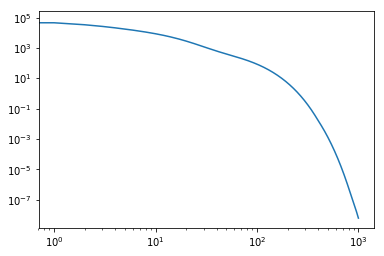

In [1311]:
import matplotlib.pyplot as plt
plt.loglog(reg.j_hist)

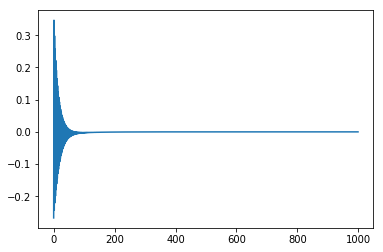

In [1314]:
plt.plot(np.array(dv_hist))

In [480]:
def compute_cost(X, y, params):
    n_samples = len(y)
    h = X @ params
    return (1/(2*n_samples))*np.sum((h-y)**2)
def gradient_descent(X, y, params, learning_rate, n_iters):
    n_samples = len(y)
    J_history = np.zeros((n_iters,1))

    for i in range(n_iters):
        params = params - (learning_rate/n_samples) * X.T @ (X @ params - y) 
        J_history[i] = compute_cost(X, y, params)

    return (J_history, params)

In [481]:
import numpy as np
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt

In [482]:
dataset = load_boston()

X = dataset.data
y = dataset.target[:,np.newaxis]

print("Total samples in our dataset is: {}".format(X.shape[0]))


Total samples in our dataset is: 506


In [229]:
n_samples = len(y)

mu = np.mean(X, 0)
sigma = np.std(X, 0)

X = (X-mu) / sigma

X = np.hstack((np.ones((n_samples,1)),X))
n_features = np.size(X,1)
params = np.zeros((n_features,1))

Initial cost is:  296.0734584980237 

Optimal parameters are: 
 [[22.53279993]
 [-0.83980839]
 [ 0.92612237]
 [-0.17541988]
 [ 0.72676226]
 [-1.82369448]
 [ 2.78447498]
 [-0.05650494]
 [-2.96695543]
 [ 1.80785186]
 [-1.1802415 ]
 [-1.99990382]
 [ 0.85595908]
 [-3.69524414]] 

Final cost is:  [11.00713381]


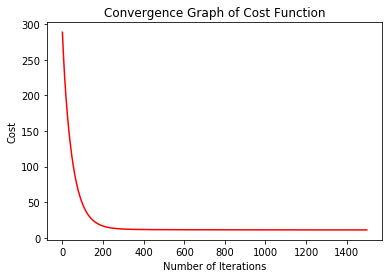

In [230]:
n_iters = 1500
learning_rate = 0.01

initial_cost = compute_cost(X, y, params)

print("Initial cost is: ", initial_cost, "\n")

(J_history, optimal_params) = gradient_descent(X, y, params, learning_rate, n_iters)

print("Optimal parameters are: \n", optimal_params, "\n")

print("Final cost is: ", J_history[-1])

plt.plot(range(len(J_history)), J_history, 'r')

plt.title("Convergence Graph of Cost Function")
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")
plt.show()

In [278]:
class LinearRegression():
    def __init__(self, X, y, alpha=0.03, n_iter=1500):

        self.alpha = alpha
        self.n_iter = n_iter
        self.n_samples = len(y)
        self.n_features = np.size(X, 1)
        self.X = np.hstack((np.ones(
            (self.n_samples, 1)), (X - np.mean(X, 0)) / np.std(X, 0)))
        self.y = y[:, np.newaxis]
        self.params = np.zeros((self.n_features + 1, 1))
        self.coef_ = None
        self.intercept_ = None
    def fit(self):

        for i in range(self.n_iter):
            self.params = self.params - (self.alpha/self.n_samples) * \
            self.X.T @ (self.X @ self.params - self.y)

        self.intercept_ = self.params[0]
        self.coef_ = self.params[1:]

        return self

    def score(self, X=None, y=None):

        if X is None:
            X = self.X
        else:
            n_samples = np.size(X, 0)
            X = np.hstack((np.ones(
                (n_samples, 1)), (X - np.mean(X, 0)) / np.std(X, 0)))

        if y is None:
            y = self.y
        else:
            y = y[:, np.newaxis]

        y_pred = X @ self.params
        score = 1 - (((y - y_pred)**2).sum() / ((y - y.mean())**2).sum())

        return score

    def predict(self, X):
        n_samples = np.size(X, 0)
        y = np.hstack((np.ones((n_samples, 1)), (X-np.mean(X, 0)) \
                            / np.std(X, 0))) @ self.params
        return y

    def get_params(self):

        return self.params

In [296]:
a = 2.71
b = -2
N = 100
x = np.linspace(0, 10, N)
x = np.expand_dims(x,1)
y = a *x + b + np.random.rand(N,1) / 0.01


In [298]:
lr = LinearRegression(x,y)
lr.fit()

In [16]:
class Variables(object):
    """
    Variable that can used to train with mask
    """
    __slots__ = ('train_mask','dim','trainable','val')
    def __init__(self, val=None, dim=None, trainable=1):
        self.dim = dim
        if val is None:
            self.val = np.random.rand(dim[0],dim[1])
            #self.val = np.zeros((dim[0],dim[1]))
        else:
            assert val.shape == dim, "input val not consistent to dim input"
            self.val = val
        self.train_mask = np.ones_like(self.val)
        self.trainable = trainable
    def set_trainMask(self, mask):
        assert mask.shape == self.dim
        self.train_mask = mask
    def update(self, dv):
        if self.trainable:
            self.val -= (dv * self.train_mask)


In [64]:
class Regression(object):
    """
    Note. Training gradient may explode if lr is too large. reprojection loss
    """
    __slots__ = ('var', 'iter', 'lr', 'err_th', 'j_hist',
                'x_mean', 'y_mean', 'x_std', 'y_std',
                'decay_rate', 'loss_weights','norm')
    def __init__(self, var=None, iter=500, decay_rate=0.9, norm=1):
        self.var = var
        self.iter = iter
        self.lr = 0.001
        self.err_th = 1e-4
        self.j_hist = np.zeros((self.iter,1))
        self.decay_rate=0.9
        self.loss_weights=None
        self.norm = norm

    def process(self, x, y):
        #self.x_mean = np.mean(x)
        self.x_std = np.std(x)
        #self.y_mean = np.mean(y)
        #self.y_std = np.std(y)
        #_x = (x.copy() - self.x_mean)/self.x_std
        #_y = (y.copy() - self.y_mean)/self.y_std
        _x = x.copy()/self.x_std
        _y = y.copy()/self.x_std
        return _x, _y
        #return x.copy(), y.copy()
    
    def pred(x,val):
        return np.dot(x, val)
    
    def compute_cost(x, val, y):
        m, n = y.shape
        pred = Regression.pred(x, val)
        dloss = pred - y
        cost = np.sum(dloss * dloss) / (2 * m * n)
        
    def fit(self, x, y):
        assert len(x.shape) == 2, 'shape of x is not support'
        assert self.var.dim[0] == x.shape[1], 'shape of x %s is not consistent to var dim %s' % (self.var.dim, x.shape)
        assert self.var.dim[1] == y.shape[1], 'shape of y %s is not consistent to var dim %s' % (self.var.dim, y.shape)
        m, n = x.shape
        print('processing data')
        _x, _y = self.process(x, y)
        dv_hist = []
        lr= self.lr
        method = 'L2norm'
        for i in range(self.iter):
            if i % 200 == 0:
                lr *= self.decay_rate
            pred = np.dot(_x, self.var.val)
            # Loss L2norm
            if self.loss_weights is not None:
                res = (pred - _y) * self.loss_weights
            else:
                res = (pred - _y)
            if method == 'L2norm':
                invH = np.linalg.inv(self.var.val)
                reproj = np.dot(pred, invH)
                res_re = (reproj - _x) * self.loss_weights
                loss = np.sum(res * res) / (2 * m * n) + np.sum(res_re * res_re) / (2 * m * n)
            elif method == 'LMS':
                loss = np.sum(np.median(res * res, axis=0)) / (2 * n)
            if self.norm > 0:
                loss += (np.sum(self.var.val ** 2) - 1) / 2 * self.norm
            self.j_hist[i,0] = loss
            if (loss < self.err_th):
                return self.var.val
            # Gradient
            if method == 'L2norm':
                # https://math.stackexchange.com/questions/190424/how-to-evaluate-the-derivatives-of-matrix-inverse
                tV = np.dot(_x.T, res) / m
                dH = -np.dot(np.dot(invH, self.var.val.T), invH)
                dR = np.dot(pred, dH)
                tV += (np.dot(dR.T, res_re) / m)
                if self.norm > 0:
                    tV += self.var.val * self.norm 
                dV = lr * tV
                dv_hist.append(dV[0,0])
            elif method == 'LMS':
                dV = (lr) # working on
            DEBUG('==============',i,'============', 'loss',loss, lr)
            # Update variable
            if self.var.trainable:
                self.var.val -= (dV * self.var.train_mask)
        print("iter Done! Final loss:", loss)
        return dv_hist
            #self.var.update(dV, self.ir, m)

In [155]:
rand = np.random.rand(N,N)
var  = Variables(val=rand,dim=(N,N))
#var  = Variables(dim=(N,N))
var.val[N-1,N-1] = 1.0
mask = np.ones_like(t_m)
mask[-1,:] = 1
mask[N-1,N-1] = 0
var.set_trainMask(mask)
reg = Regression(var=var,iter=1000)
reg.err_th = 1e-10
#reg.lr = 0.000001
#reg.lr = np.ones((N,N)) * 0.01
#reg.lr[-1,:] = 0.0001
reg.lr = 0.1
reg.norm = 1e-8
reg.loss_weights = np.array([[1,1,1]])

In [156]:
dv_hist = reg.fit(data_x, data_y)

processing data
============== 0 ============ loss 116014.94453889747 0.09000000000000001
============== 1 ============ loss 22144.163619434694 0.09000000000000001
============== 2 ============ loss 6089.0714430236585 0.09000000000000001
============== 3 ============ loss 3273.3673188490893 0.09000000000000001
============== 4 ============ loss 2712.7321334867115 0.09000000000000001
============== 5 ============ loss 2538.658798665922 0.09000000000000001
============== 6 ============ loss 2433.211939650282 0.09000000000000001
============== 7 ============ loss 2342.2069540665484 0.09000000000000001
============== 8 ============ loss 2256.326148113136 0.09000000000000001
============== 9 ============ loss 2173.887221394699 0.09000000000000001
============== 10 ============ loss 2094.5101826155715 0.09000000000000001
============== 11 ============ loss 2018.0399845150655 0.09000000000000001
============== 12 ============ loss 1944.3631428361227 0.09000000000000001
============== 13 =====

============== 118 ============ loss 37.726046908211856 0.09000000000000001
============== 119 ============ loss 36.34874191500853 0.09000000000000001
============== 120 ============ loss 35.021720929076224 0.09000000000000001
============== 121 ============ loss 33.74314813274945 0.09000000000000001
============== 122 ============ loss 32.511254732179815 0.09000000000000001
============== 123 ============ loss 31.32433651036591 0.09000000000000001
============== 124 ============ loss 30.180751469519826 0.09000000000000001
============== 125 ============ loss 29.078917559506188 0.09000000000000001
============== 126 ============ loss 28.01731048921618 0.09000000000000001
============== 127 ============ loss 26.99446161784433 0.09000000000000001
============== 128 ============ loss 26.008955923153707 0.09000000000000001
============== 129 ============ loss 25.05943004391651 0.09000000000000001
============== 130 ============ loss 24.144570393824324 0.09000000000000001
============== 131

============== 262 ============ loss 0.22570251284208398 0.08100000000000002
============== 263 ============ loss 0.21831116516551327 0.08100000000000002
============== 264 ============ loss 0.21116291011560792 0.08100000000000002
============== 265 ============ loss 0.20424975268781856 0.08100000000000002
============== 266 ============ loss 0.19756396082259015 0.08100000000000002
============== 267 ============ loss 0.19109805675757918 0.08100000000000002
============== 268 ============ loss 0.18484480866408198 0.08100000000000002
============== 269 ============ loss 0.17879722255867905 0.08100000000000002
============== 270 ============ loss 0.17294853448075748 0.08100000000000002
============== 271 ============ loss 0.16729220292741193 0.08100000000000002
============== 272 ============ loss 0.16182190153712836 0.08100000000000002
============== 273 ============ loss 0.15653151201398585 0.08100000000000002
============== 274 ============ loss 0.1514151172847922 0.08100000000000002


============== 394 ============ loss 0.003685811862059613 0.08100000000000002
============== 395 ============ loss 0.0035963618601692797 0.08100000000000002
============== 396 ============ loss 0.003509853897663259 0.08100000000000002
============== 397 ============ loss 0.0034261912124012367 0.08100000000000002
============== 398 ============ loss 0.0033452802246455946 0.08100000000000002
============== 399 ============ loss 0.003267030432427864 0.08100000000000002
============== 400 ============ loss 0.0031913543102859085 0.07290000000000002
============== 401 ============ loss 0.0031254308476047193 0.07290000000000002
============== 402 ============ loss 0.003061460446536621 0.07290000000000002
============== 403 ============ loss 0.0029993852469360326 0.07290000000000002
============== 404 ============ loss 0.002939149102754309 0.07290000000000002
============== 405 ============ loss 0.0028806975312610427 0.07290000000000002
============== 406 ============ loss 0.002823977663785937

============== 532 ============ loss 0.0010082589386043977 0.07290000000000002
============== 533 ============ loss 0.0010070150477054201 0.07290000000000002
============== 534 ============ loss 0.0010058080217918597 0.07290000000000002
============== 535 ============ loss 0.0010046367685281061 0.07290000000000002
============== 536 ============ loss 0.0010035002279409756 0.07290000000000002
============== 537 ============ loss 0.001002397371463358 0.07290000000000002
============== 538 ============ loss 0.0010013272010006076 0.07290000000000002
============== 539 ============ loss 0.0010002887480309516 0.07290000000000002
============== 540 ============ loss 0.0009992810727265818 0.07290000000000002
============== 541 ============ loss 0.0009983032631053898 0.07290000000000002
============== 542 ============ loss 0.0009973544342055227 0.07290000000000002
============== 543 ============ loss 0.0009964337272843676 0.07290000000000002
============== 544 ============ loss 0.00099554030904

============== 688 ============ loss 0.0009668006797206002 0.06561000000000002
============== 689 ============ loss 0.0009667873536254029 0.06561000000000002
============== 690 ============ loss 0.0009667743844593516 0.06561000000000002
============== 691 ============ loss 0.0009667617626805677 0.06561000000000002
============== 692 ============ loss 0.0009667494790019137 0.06561000000000002
============== 693 ============ loss 0.0009667375243844198 0.06561000000000002
============== 694 ============ loss 0.0009667258900304918 0.06561000000000002
============== 695 ============ loss 0.0009667145673774964 0.06561000000000002
============== 696 ============ loss 0.0009667035480915269 0.06561000000000002
============== 697 ============ loss 0.000966692824061232 0.06561000000000002
============== 698 ============ loss 0.0009666823873919451 0.06561000000000002
============== 699 ============ loss 0.0009666722303998806 0.06561000000000002
============== 700 ============ loss 0.00096666234560

============== 868 ============ loss 0.0009663089577844541 0.05904900000000002
============== 869 ============ loss 0.0009663088547838579 0.05904900000000002
============== 870 ============ loss 0.0009663087543644181 0.05904900000000002
============== 871 ============ loss 0.0009663086564628259 0.05904900000000002
============== 872 ============ loss 0.0009663085610173104 0.05904900000000002
============== 873 ============ loss 0.0009663084679675972 0.05904900000000002
============== 874 ============ loss 0.0009663083772548809 0.05904900000000002
============== 875 ============ loss 0.0009663082888217737 0.05904900000000002
============== 876 ============ loss 0.0009663082026122944 0.05904900000000002
============== 877 ============ loss 0.0009663081185718121 0.05904900000000002
============== 878 ============ loss 0.0009663080366470291 0.05904900000000002
============== 879 ============ loss 0.0009663079567859404 0.05904900000000002
============== 880 ============ loss 0.0009663078789

In [153]:
t_m

array([[ 7.92272362e-01,  8.22117652e-02,  4.34671442e+02],
       [-1.33501977e-01,  9.58413827e-01,  6.55962640e+01],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])

In [158]:
reg.var.val

array([[ 7.90900075e-01,  8.06359397e-02,  4.34671372e+02],
       [-1.33281047e-01,  9.58667338e-01,  6.55963190e+01],
       [ 6.01986564e-01,  6.91658939e-01,  1.00000000e+00]])

In [160]:
for idx in range(4):
    test_x = data_x[idx]
    test_y = data_y[idx]
    pred_y = np.dot(data_x[idx], reg.var.val)
    print (data_x[idx], test_y, pred_y)

[366 632   1] [   205.59822578    635.80706082 200547.58662   ] [   205.83779247    636.08217029 200547.59589302]
[691 937   1] [   422.36864044    954.84210175 361822.66579   ] [   422.22959761    954.68238868 361822.66920104]
[386  74   1] [2.95937776e+02 1.02656381e+02 1.72638300e+05] [2.96026618e+02 1.02758515e+02 1.72638277e+05]
[570 609   1] [   370.2923331    630.5347429 287711.846716 ] [   370.24687188    630.48255322 287711.84051069]


In [56]:
def calc_corresp(u, v):
    # 2N * 9
    a = np.array([[-u[0,0], -u[0,1], -1, 0, 0, 0, u[0,0]*v[0,0], u[0,1]*v[0,0], v[0,0]],
                  [0, 0, 0, -u[0,0], -u[0,1], -1, u[0,0]*v[0,1], u[0,1]*v[0,1], v[0,1]],
                  [-u[1,0], -u[1,1], -1, 0, 0, 0, u[1,0]*v[1,0], u[1,1]*v[1,0], v[1,0]],
                  [0, 0, 0, -u[1,0], -u[1,1], -1, u[1,0]*v[1,1], u[1,1]*v[1,1], v[1,1]],
                  [-u[2,0], -u[2,1], -1, 0, 0, 0, u[2,0]*v[2,0], u[2,1]*v[2,0], v[2,0]],
                  [0, 0, 0, -u[2,0], -u[2,1], -1, u[2,0]*v[2,1], u[2,1]*v[2,1], v[2,1]],
                  [-u[3,0], -u[3,1], -1, 0, 0, 0, u[3,0]*v[3,0], u[3,1]*v[3,0], v[3,0]],
                  [0, 0, 0, -u[3,0], -u[3,1], -1, u[3,0]*v[3,1], u[3,1]*v[3,1], v[3,1]]]).astype(np.float32)
    return a

def calc_correspLinear(u, v):
    # 2N * 8 see https://scm_mos.gitlab.io/vision/homography-matrix/
    a = np.array([[u[0,0], u[0,1], 1, 0, 0, 0, -u[0,0]*v[0,0], -u[0,1]*v[0,0]],
                  [0, 0, 0, u[0,0], u[0,1], 1, -u[0,0]*v[0,1], -u[0,1]*v[0,1]],
                  [u[1,0], u[1,1], 1, 0, 0, 0, -u[1,0]*v[1,0], -u[1,1]*v[1,0]],
                  [0, 0, 0, u[1,0], u[1,1], 1, -u[1,0]*v[1,1], -u[1,1]*v[1,1]],
                  [u[2,0], u[2,1], 1, 0, 0, 0, -u[2,0]*v[2,0], -u[2,1]*v[2,0]],
                  [0, 0, 0, u[2,0],u[2,1], 1, -u[2,0]*v[2,1], -u[2,1]*v[2,1]],
                  [u[3,0], u[3,1], 1, 0, 0, 0, -u[3,0]*v[3,0], -u[3,1]*v[3,0]],
                  [0, 0, 0, u[3,0], u[3,1], 1, -u[3,0]*v[3,1], -u[3,1]*v[3,1]]]).astype(np.float32)

    b = np.array([[v[0,0], v[0,1], v[1,0], v[1,1], v[2,0], v[2,1], v[3,0], v[3,1]]]).astype(np.float32).T
    return a, b

def calcHomography(u, v):
    """DLT algo"""

    # get assemable matrix
    mat = calc_corresp(u, v)
    
    # svd composition
    u, s, v = np.linalg.svd(mat)
    
    # reshape
    h = v[-1].reshape(3, 3)
    
    # norm
    h = h / h.item(8)
    return h

def calcHomographyLinear(u, v):
    """Linear"""

    # get assemable matrix
    A, b = calc_correspLinear(u, v)
    
    # solver linear AH = b, H = (A.T * A)^-1 * A.T * b
    h = np.linalg.inv(A.T @ A) @ (A.T @ b)
    
    H = np.array([[h.item(0), h.item(1), h.item(2)],
                  [h.item(3), h.item(4), h.item(5)],
                  [h.item(6), h.item(7), 1]])
    return H

def backwrap(im, pts4, h):
    # fwd pts 4
    fwd = h @ pts4
    fwd /= fwd[-1,:]
    

In [57]:
## test self determine coord
data_x = np.array([[400., 600, 450, 620],
                  [100, 200, 620, 700],
                  [1, 1, 1, 1]]).astype(np.float32).T
data_y = np.array([[0, 400, 0, 400],
                  [0., 0, 400, 400],
                  [1, 1, 1, 1]]).astype(np.float32).T


In [58]:
h = calcHomography(data_x.T[:,:2], dy.T[:,:2])

NameError: name 'dy' is not defined

In [59]:
h = calcHomographyLinear(data_x[:,:2], data_y[:,:2])
#h = calcHomographyLinear(data_x.T[:,:2], dy.T[:,:2])

In [60]:
h

array([[ 2.08819580e+00, -2.00794220e-01, -8.15187500e+02],
       [-3.45853806e-01,  6.91696167e-01,  6.91699219e+01],
       [ 8.86917114e-05, -2.96704471e-04,  1.00000000e+00]])

In [61]:
data_x

array([[400., 100.,   1.],
       [600., 200.,   1.],
       [450., 620.,   1.],
       [620., 700.,   1.]], dtype=float32)

In [62]:
y = (h @ data_x.T)
y /= y[-1,:]

In [63]:
(y * 100).astype(np.int)/100

array([[1.0000e-02, 4.0002e+02, 0.0000e+00, 4.0002e+02],
       [0.0000e+00, 0.0000e+00, 4.0000e+02, 4.0001e+02],
       [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]])

In [64]:
data_y

array([[  0.,   0.,   1.],
       [400.,   0.,   1.],
       [  0., 400.,   1.],
       [400., 400.,   1.]], dtype=float32)

In [16]:
data_y = np.array([[0,0,1],[400,0,1],[400,800,1],[0,800,1]]).astype(np.float32)


In [23]:
data_x = np.array([[200,300,1],[300,280,1],[500,700,1],[185,710,1]]).astype(np.float32)

In [118]:


H = calcHomographyLinear(data_x[:,:2], data_y[:,:2])

In [ ]:
def getMaxBnd(z):
    np.max()

In [116]:
h

120

In [24]:
y = h @ data_x.T 

In [32]:
z = (y / y[-1,:]).astype(np.int32)

In [29]:
hinv = np.linalg.inv(h)

In [34]:
zT = hinv @ z 

array([[200.00212766, 299.74764129, 499.11461884, 185.00275143],
       [300.00792153, 280.0596983 , 700.02597518, 709.99464953],
       [  1.        ,   1.        ,   1.        ,   1.        ]])